In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import numpy as np
import tensorflow as tf

plt.style.use('seaborn')

# Обзор датасета [🌸 | Flowers](https://www.kaggle.com/datasets/l3llff/flowers?resource=download)

In [65]:
dir = 'dataset/'

Количесвто изображений в каждом классе:

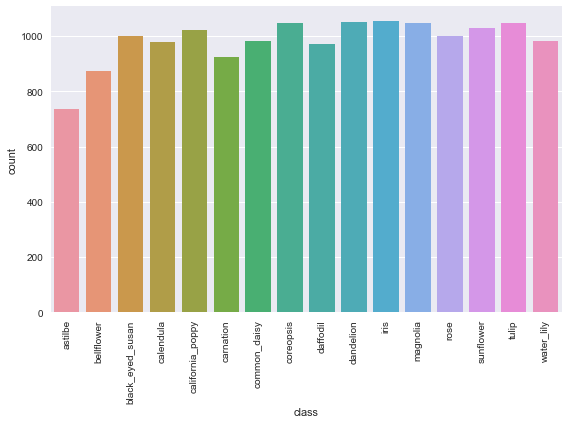

In [66]:
DF = pd.DataFrame(columns=['class','count'])
DF['class']=pd.Series([os.listdir(dir)[x] for x in range(0,16)])
DF['count']=pd.Series([len(os.listdir(os.path.join(dir,os.listdir(dir)[x]))) for x in range(0,16)])
plt.figure(figsize=(8,6))
g=sns.barplot(x='class', y='count',data=DF)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.tight_layout()

Доля объектов в каждом классе:

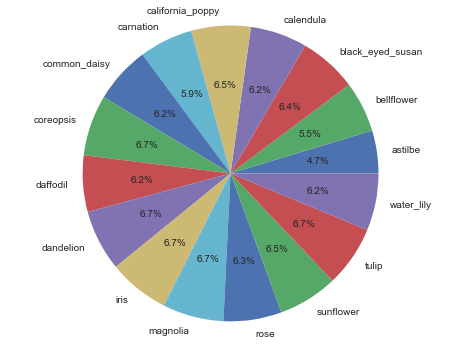

In [69]:
plt.figure(figsize=(8,6))
plt.tight_layout()
plt.pie(DF['count'],
        labels=DF['class'],
        autopct='%1.1f%%')
plt.axis('equal')
plt.show()

Количество изображений практически одинаково в каждом классе, поэтому данные будем считать **сбалансированными**.

Пример изображений в датасете:

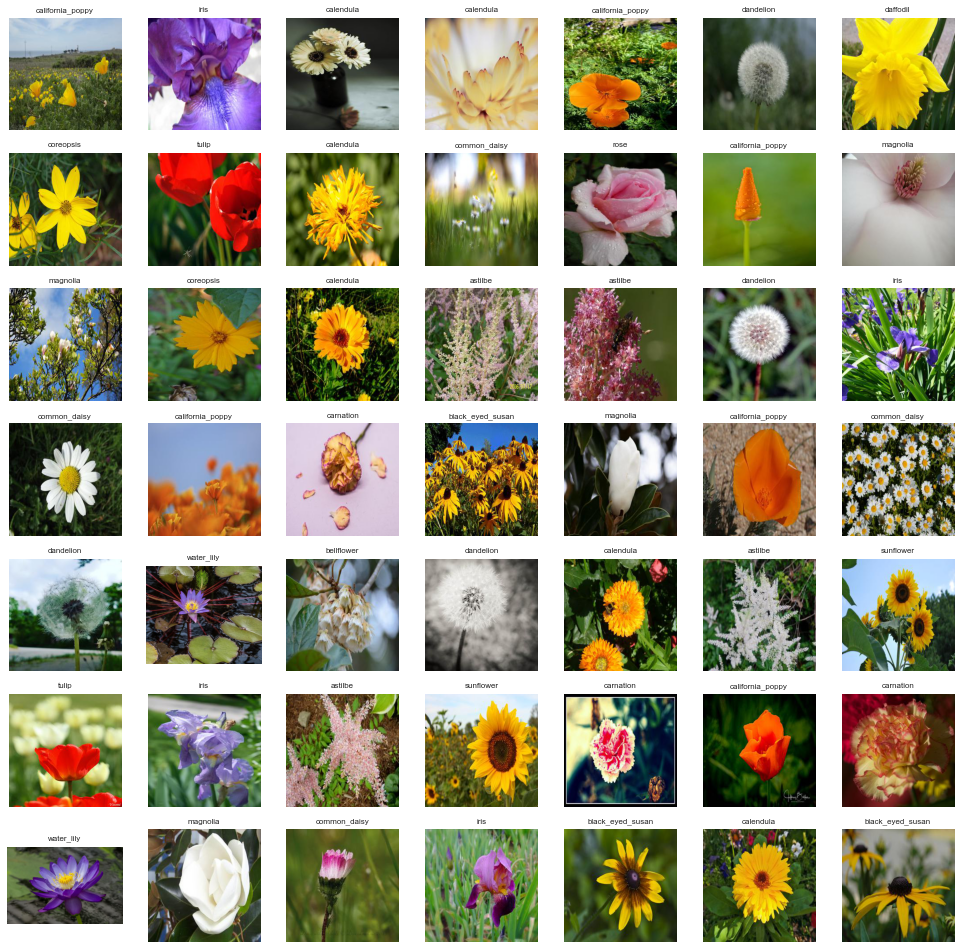

In [70]:
# visualize the training data
W = 7
H = 7
fig, axes = plt.subplots(W, H, figsize = (17,17))

axes = axes.ravel() # flaten the matrix into array
# Select a random number from 0 to n_training/ images will be selected randomly
for i in np.arange(0, W * H): 
    # Select a class randomly
    label = random.choice(os.listdir(dir))
    class_dir = os.path.join(dir,label)
    # Select a random image
    image = random.choice(os.listdir(class_dir))
    # read and display an image with the selected index    
    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    #print(np.array(img).shape)
    axes[i].set_title(label, fontsize = 8) # the label
    axes[i].axis('off')

In [18]:
np.array(img).shape

(256, 256, 3)

# Подготовка данных

Проведем аугментацию исходных данных с использованием следующих преобрахований:
- rotation_range
- width_shift_range
- height_shift_range
- shear_range
- zoo_range
- horizontal_flip
- vertical_flip
- brightness_range

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator( rescale = 1.0/255.,
                                  rotation_range=30 ,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  brightness_range=[0.6,1],
                                  fill_mode='nearest',
                                  validation_split=0.2)

Также разделим данные на тренировочную и валидационную часть:

In [52]:
train_generator = datagen.flow_from_directory(dir,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(150, 150),
                                                    subset='training' ) 
val_generator = datagen.flow_from_directory(dir,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(150, 150),
                                                    shuffle=False,
                                                    subset='validation' ) 

Found 12599 images belonging to 16 classes.
Found 3141 images belonging to 16 classes.


In [24]:
train_generator.class_indices

{'astilbe': 0,
 'bellflower': 1,
 'black_eyed_susan': 2,
 'calendula': 3,
 'california_poppy': 4,
 'carnation': 5,
 'common_daisy': 6,
 'coreopsis': 7,
 'daffodil': 8,
 'dandelion': 9,
 'iris': 10,
 'magnolia': 11,
 'rose': 12,
 'sunflower': 13,
 'tulip': 14,
 'water_lily': 15}

Пример изображений после аугментации:

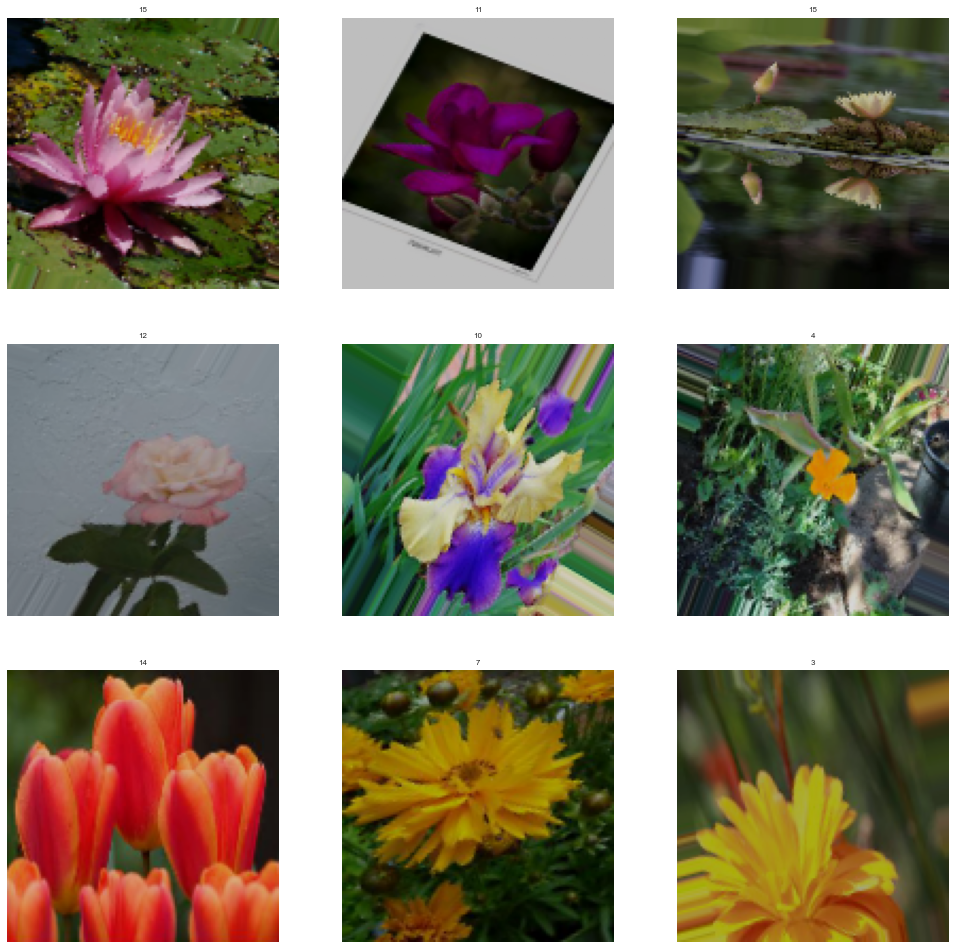

In [72]:
W = 3
H = 3
x_batch, y_batch = next(train_generator)
fig, axes = plt.subplots(W, H, figsize = (17,17))

axes = axes.ravel() # flaten the matrix into array
for i in np.arange(0, W * H): 

    # Select a random image
    image = x_batch[i]
    # read and display an image with the selected index    
    axes[i].imshow( image )
    axes[i].set_title(np.argmax(y_batch[i]), fontsize = 8) # the label
    axes[i].axis('off')

Для решения задачи будем использовать подход Transfer Learning и Fine Tuning.

# Transfer Learning

**Transfer Learning** позволяет позволяет использовать другие существующие модели, которые были обучены на большом количестве данных, в рамках конкретной задачи.

In [25]:
# feature extractor
denseNet = tf.keras.applications.DenseNet121(include_top=False,
                                             weights="imagenet",
                                             input_shape=(150, 150, 3))
#freeze the base model [denseNet]
denseNet.trainable = False
#add the classifier
model = tf.keras.models.Sequential()
model.add(denseNet)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(16, activation='softmax'))

29084464/29084464 [==============================] - 3s 0us/step


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 4, 4, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 512)               8389120   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
Total params: 15,494,352
Trainable params: 8,456,848
Non

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
#earlystop = EarlyStopping(monitor='loss', patience=5)
epoch = 10 
history = model.fit(train_generator, epochs = epoch, validation_data = val_generator, verbose = 1)

Epoch 1/10
394/394 [==============================] - 400s 1s/step - loss: 1.3237 - accuracy: 0.6239 - val_loss: 0.6952 - val_accuracy: 0.7956
Epoch 2/10
394/394 [==============================] - 366s 929ms/step - loss: 0.7416 - accuracy: 0.7724 - val_loss: 0.6127 - val_accuracy: 0.8067
Epoch 3/10
394/394 [==============================] - 367s 931ms/step - loss: 0.5998 - accuracy: 0.8141 - val_loss: 0.5485 - val_accuracy: 0.8341
Epoch 4/10
394/394 [==============================] - 370s 940ms/step - loss: 0.5146 - accuracy: 0.8417 - val_loss: 0.6353 - val_accuracy: 0.8138
Epoch 5/10
394/394 [==============================] - 361s 917ms/step - loss: 0.4780 - accuracy: 0.8489 - val_loss: 0.5240 - val_accuracy: 0.8399
Epoch 6/10
394/394 [==============================] - 356s 903ms/step - loss: 0.4331 - accuracy: 0.8631 - val_loss: 0.5591 - val_accuracy: 0.8348
Epoch 7/10
394/394 [==============================] - 355s 902ms/step - loss: 0.4077 - accuracy: 0.8721 - val_loss: 0.5145 - va

In [28]:
def evaluation(history):
    # evaluation
    #-----------------------------------------------------------
    # Retrieve a list of list results on training and test data
    # sets for each training epoch
    #-----------------------------------------------------------
    acc      = history.history['accuracy']
    val_acc  = history.history['val_accuracy']
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    epochs   = range(len(acc)) # Get number of epochs

    #------------------------------------------------
    # Plot training and validation accuracy per epoch
    #------------------------------------------------
    plt.figure(figsize=(10,6))
    plt.plot  ( epochs,     acc )
    plt.plot  ( epochs, val_acc )
    plt.title ('Training and validation accuracy')
    plt.legend()
    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.figure(figsize=(10,6))
    plt.plot  ( epochs,     loss )
    plt.plot  ( epochs, val_loss )
    plt.title ('Training and validation loss'   )

No handles with labels found to put in legend.


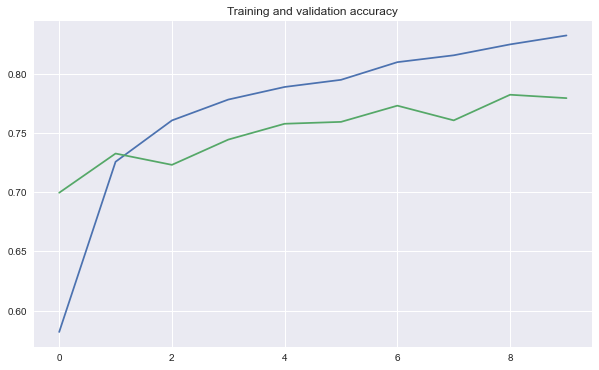

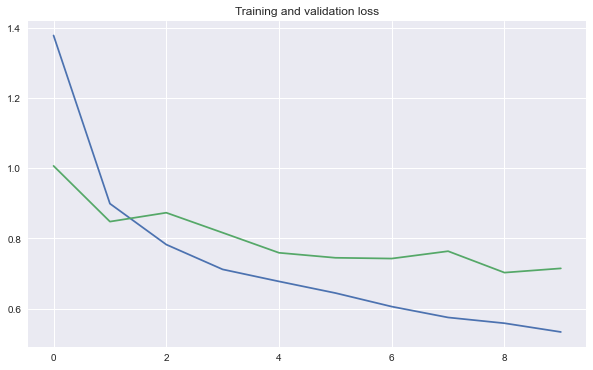

In [74]:
evaluation(history)

Матрица сопряженности:

50/50 [==============================] - 117s 2s/step - loss: 0.7150 - accuracy: 0.7743
Confusion Matrix
[[114   5   0   1   5  11   2   0   0   1   0   5   1   0   0   2]
 [  5 102   0   3  11   7   3   2   2   0  11  14   3   0   1  10]
 [  0   1 180   2   2   1   1   7   0   0   0   1   0   3   1   1]
 [  1   3   4 112  14  10   2  15   3   3   0   5   2  10   8   3]
 [  1   1   1   6 157   6   0   1   7   2   2   7   4   3   3   3]
 [  4   5   1   7   3 118   1   0   1   0   5  17   8   3   4   7]
 [  4   5   1   5   7   4 144   0   1   5   1   7   0   2   5   5]
 [  3   2  13  19  12   2   5 134   7   1   1   3   0   5   0   2]
 [  0   1   1   0   6   3   2   2 168   0   1   7   0   2   0   1]
 [  2   0   0   4   1   1  11   2   2 187   0   0   0   0   0   0]
 [  0   4   0   0   0   4   0   0   3   0 194   4   0   0   0   1]
 [  2   4   0   0   5  11   3   1   2   1   2 169   0   1   2   6]
 [  1   5   0   0   8  12   0   0   1   0   0   9 158   0   2   3]
 [  0   1   2   3   0   

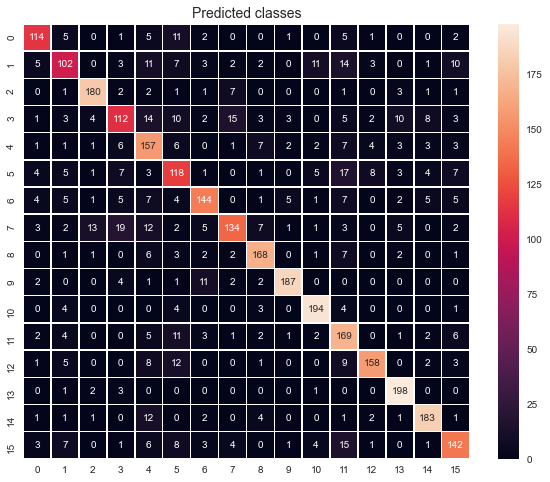

In [73]:
from sklearn.metrics import confusion_matrix, classification_report
Y_pred = model.predict(val_generator)
model.evaluate(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))
print('Classification Report')
target_names = ['astilbe','bellflower','black_eyed_susan','calendula','california_poppy','carnation','common_daisy','coreopsis','daffodil',
                'dandelion','iris','magnolia','rose','sunflower','tulip','water_lily']
print(classification_report(val_generator.classes, y_pred, target_names=target_names))
plt.figure(figsize=(10,8))
plt.title('Predicted classes', size=14)
sns.heatmap(confusion_matrix(val_generator.classes, y_pred), annot=True, fmt = '.0f',linewidths=.5)
plt.show()

# Fine Tuning

In [31]:
print('Number of layers in the denseNet121 Model : ', len(denseNet.layers))

Number of layers in the denseNet121 Model :  427


In [32]:
# lets fine tune from 350th layer 
for layer in denseNet.layers[400:]:
    layer.trainable=True

In [33]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='loss', patience=5)
epoch = 20 
history = model.fit(train_generator, epochs = epoch, validation_data = val_generator, verbose = 1, callbacks=[earlystop])

Epoch 1/20
394/394 [==============================] - 426s 1s/step - loss: 0.4699 - accuracy: 0.8559 - val_loss: 0.5866 - val_accuracy: 0.8450
Epoch 2/20
394/394 [==============================] - 407s 1s/step - loss: 0.4162 - accuracy: 0.8736 - val_loss: 0.5834 - val_accuracy: 0.8475
Epoch 3/20
394/394 [==============================] - 406s 1s/step - loss: 0.3988 - accuracy: 0.8769 - val_loss: 0.5637 - val_accuracy: 0.8478
Epoch 4/20
394/394 [==============================] - 403s 1s/step - loss: 0.3726 - accuracy: 0.8855 - val_loss: 0.5146 - val_accuracy: 0.8685
Epoch 5/20
394/394 [==============================] - 396s 1s/step - loss: 0.3551 - accuracy: 0.8924 - val_loss: 0.5670 - val_accuracy: 0.8535
Epoch 6/20
394/394 [==============================] - 387s 981ms/step - loss: 0.3431 - accuracy: 0.8963 - val_loss: 0.6299 - val_accuracy: 0.8373
Epoch 7/20
394/394 [==============================] - 397s 1s/step - loss: 0.3398 - accuracy: 0.8940 - val_loss: 0.5695 - val_accuracy: 0.8

No handles with labels found to put in legend.


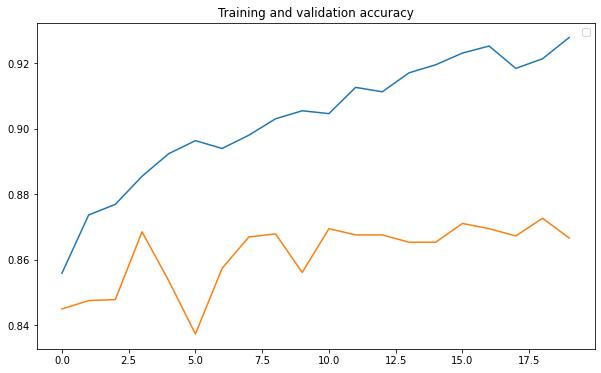

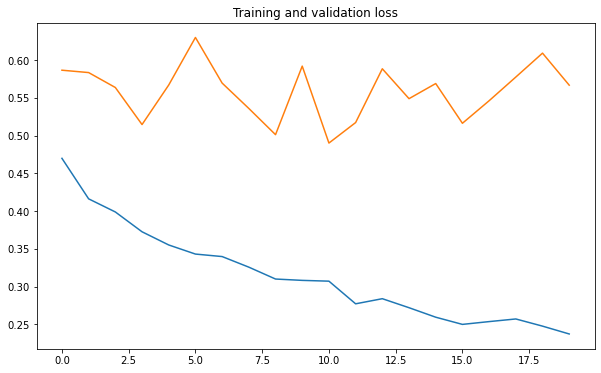

In [34]:
evaluation(history)

99/99 [==============================] - 70s 700ms/step - loss: 0.5402 - accuracy: 0.8606
Confusion Matrix
[[126   4   0   2   2   4   3   1   0   2   0   1   0   0   0   2]
 [  3 144   0   2   2   5   1   0   3   0   5   3   0   0   1   5]
 [  0   0 185   4   0   0   0  10   0   0   0   0   0   1   0   0]
 [  0   1   0 150  11   6   2  10   2   3   0   1   0   6   1   2]
 [  1   3   0   8 168   2   2   5   1   1   1   3   2   1   0   6]
 [  6   5   0   3   0 144   6   0   0   0   3   2  10   0   1   4]
 [  2   2   0   3   1   3 174   1   0   0   0   0   0   0   4   6]
 [  1   1   7  12   1   0   3 180   1   1   0   1   0   0   0   1]
 [  0   1   1   3   3   0   1   5 179   0   0   1   0   0   0   0]
 [  0   1   0   2   0   0   2   0   0 204   0   0   0   0   0   1]
 [  0  14   0   0   0   1   0   0   5   0 189   1   0   0   0   0]
 [  5  18   0   1   1  15   0   0   1   0   1 155   1   0   4   7]
 [  0   1   0   0   1  18   0   0   1   0   0   3 168   0   6   1]
 [  0   0   0   3   0 

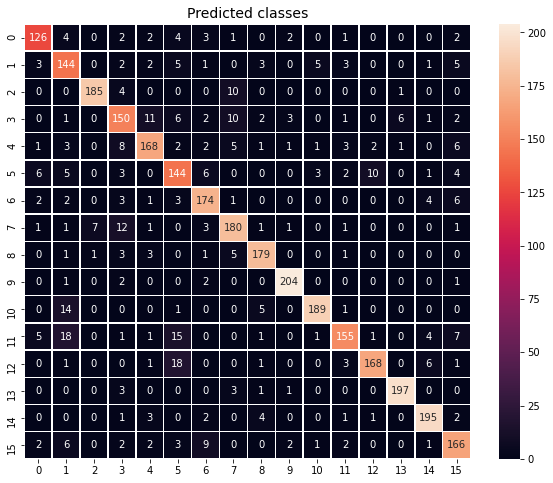

In [35]:
from sklearn.metrics import confusion_matrix, classification_report
Y_pred = model.predict(val_generator)
model.evaluate(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))
print('Classification Report')
target_names = ['astilbe','bellflower','black_eyed_susan','calendula','california_poppy','carnation','common_daisy','coreopsis','daffodil',
                'dandelion','iris','magnolia','rose','sunflower','tulip','water_lily']
print(classification_report(val_generator.classes, y_pred, target_names=target_names))
plt.figure(figsize=(10,8))
plt.title('Predicted classes', size=14)
sns.heatmap(confusion_matrix(val_generator.classes, y_pred), annot=True, fmt = '.0f',linewidths=.5)
plt.show()

# VGG16

In [56]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten,MaxPool2D, BatchNormalization, Conv2D, Dropout
from tensorflow.keras import Model

base_model = VGG16(weights='imagenet', include_top=False,
                            input_shape=(150, 150, 3))

# freeze extraction layers
base_model.trainable = False

# add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(base_model.output)
predictions = Dense(16, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

In [57]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [58]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [59]:
train_generator = datagen.flow_from_directory(dir,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    target_size=(128, 128),
                                                    subset='training' ) 
val_generator = datagen.flow_from_directory(dir,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    target_size=(128, 128),
                                                    shuffle=False,
                                                    subset='validation' ) 

Found 12599 images belonging to 16 classes.
Found 3141 images belonging to 16 classes.


In [60]:
history = model.fit(train_generator,
                    epochs = 10,
                    validation_data = val_generator,
                    verbose = 1)

Epoch 1/10
197/197 [==============================] - 539s 3s/step - loss: 1.3783 - accuracy: 0.5819 - val_loss: 1.0067 - val_accuracy: 0.6995
Epoch 2/10
197/197 [==============================] - 515s 3s/step - loss: 0.8992 - accuracy: 0.7256 - val_loss: 0.8480 - val_accuracy: 0.7326
Epoch 3/10
197/197 [==============================] - 516s 3s/step - loss: 0.7826 - accuracy: 0.7605 - val_loss: 0.8733 - val_accuracy: 0.7230
Epoch 4/10
197/197 [==============================] - 516s 3s/step - loss: 0.7119 - accuracy: 0.7782 - val_loss: 0.8164 - val_accuracy: 0.7443
Epoch 5/10
197/197 [==============================] - 518s 3s/step - loss: 0.6776 - accuracy: 0.7888 - val_loss: 0.7592 - val_accuracy: 0.7577
Epoch 6/10
197/197 [==============================] - 516s 3s/step - loss: 0.6446 - accuracy: 0.7948 - val_loss: 0.7450 - val_accuracy: 0.7593
Epoch 7/10
197/197 [==============================] - 511s 3s/step - loss: 0.6059 - accuracy: 0.8097 - val_loss: 0.7428 - val_accuracy: 0.7730

No handles with labels found to put in legend.


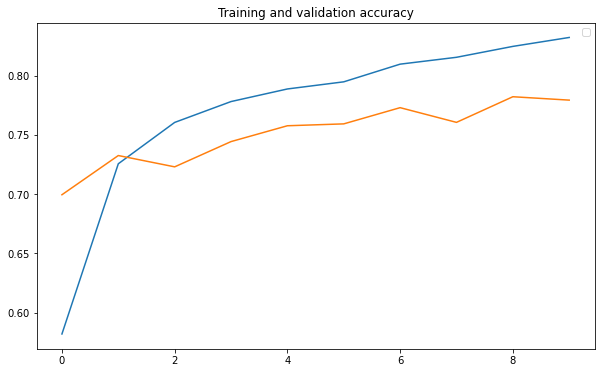

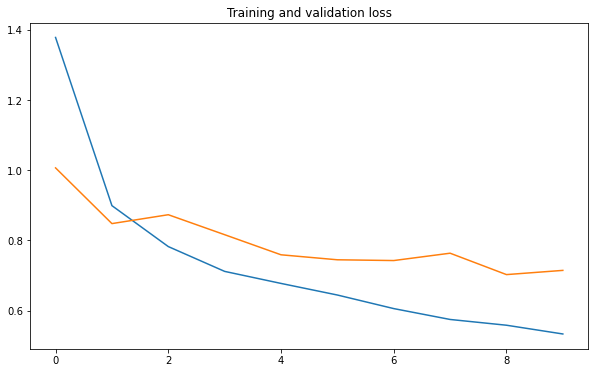

In [61]:
evaluation(history)

50/50 [==============================] - 119s 2s/step - loss: 0.6897 - accuracy: 0.7841
Confusion Matrix
[[113   5   0   1   2   4   3   0   0   2   0  11   1   1   0   4]
 [  3  99   1   2  11   7   4   2   2   2  13  18   3   1   1   5]
 [  0   0 175   4   2   0   0  13   1   0   0   0   0   4   0   1]
 [  0   0   2  98  22  10   3  18   1   4   5   2   2  17   5   6]
 [  0   2   0   5 153   6   0   4   7   0   0  10   4   5   4   4]
 [  6   3   0   9   2 119   3   1   1   0   5  16   5   2   6   6]
 [  5   3   1   4   6   7 151   0   1   2   0   6   0   1   4   5]
 [  3   3  11  24   7   5   5 138   4   0   2   1   0   4   0   2]
 [  0   4   2   2   7   2   0   1 167   0   1   3   0   2   1   2]
 [  4   0   1   4   2   0   7   1   1 189   0   0   0   1   0   0]
 [  0   4   0   0   0   0   0   0   6   0 194   4   1   0   0   1]
 [  2   5   0   0   6   8   1   0   2   0   1 176   1   1   1   5]
 [  1   4   0   2   7  18   0   0   1   0   1   8 152   0   1   4]
 [  0   1   0   1   2   

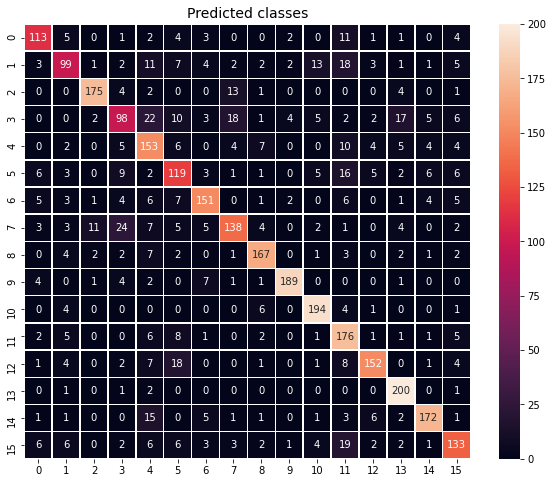

In [62]:
from sklearn.metrics import confusion_matrix, classification_report
Y_pred = model.predict(val_generator)
model.evaluate(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))
print('Classification Report')
target_names = ['astilbe','bellflower','black_eyed_susan','calendula','california_poppy','carnation','common_daisy','coreopsis','daffodil',
                'dandelion','iris','magnolia','rose','sunflower','tulip','water_lily']
print(classification_report(val_generator.classes, y_pred, target_names=target_names))
plt.figure(figsize=(10,8))
plt.title('Predicted classes', size=14)
sns.heatmap(confusion_matrix(val_generator.classes, y_pred), annot=True, fmt = '.0f',linewidths=.5)
plt.show()